In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm # loop vizualization

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])

In [4]:
train_ds = datasets.MNIST(
    root="MNIST_data",
    train=True,
    download=True,
    transform=transform,
)
test_ds = datasets.MNIST(
    root="MNIST_data",
    train=False,
    download=True,
    transform=transform,
)

In [5]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


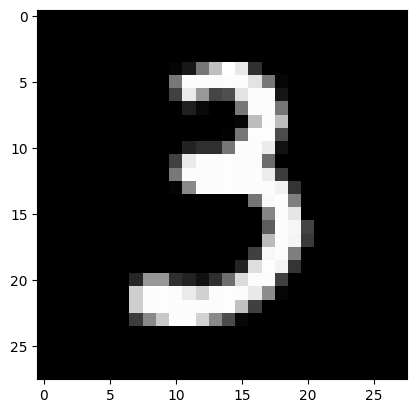

Label: 3


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Преобразуем входной тензор в одномерный вектор
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [8]:
model = NN()
model.to(device)

NN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [10]:
num_iter = 10
losses = []
for i in tqdm(range(num_iter)):
    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        outputs = model(data)
        loss = loss_func(outputs, label)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 10/10 [00:42<00:00,  4.30s/it]


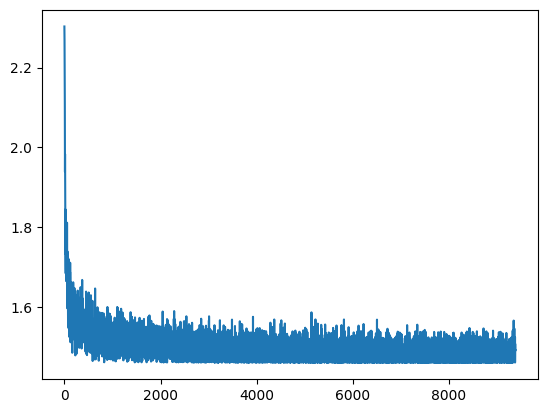

In [11]:
plt.plot(losses)

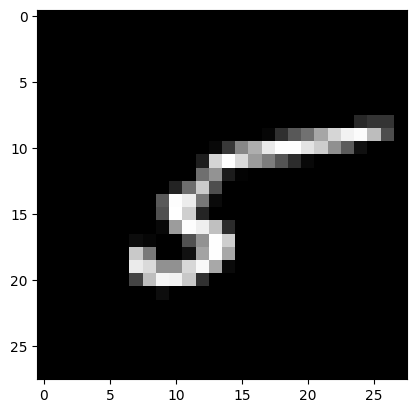

Label: 5
Pred: 5


In [17]:
# Model test
test_features, test_labels = next(iter(test_dataloader))
img = test_features[0].squeeze()
label = test_labels[0]
pred = model(test_features[0].to(device)).argmax()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(f"Pred: {pred}")

In [13]:
# Accuracy
correct = 0
total = len(test_dataloader)
for data, label in test_dataloader:
    data = data.to(device)
    output = model(data).argmax().cpu()
    if (output == label):
        correct += 1
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


Predicted value = 4
Your image:


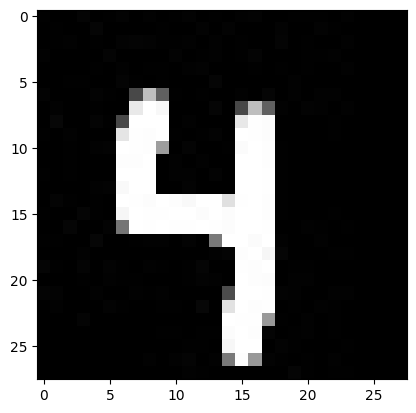

In [18]:
# Open your image from file
from PIL import Image
path = "MyImg.jpg"
img = Image.open(path)
img_tensor = transforms.ToTensor()(img)
print(f"Predicted value = {model(img_tensor[0].to(device)).argmax()}")
print("Your image:")
plt.imshow(img_tensor[0].detach().numpy(), cmap="gray")